Discord Clone Tutorial Part 1

## Tutorial part 1: 
* Setting up Convex
* Setting up Clerk
* Setting Friends dashboard

# Getting starter
Install packages and dependencies
```bash
pnpm convex dev
pnpm add -D npm-run-all
pnpm add @clerk/nextjs
```

# Build Basic Static UI for messaging.

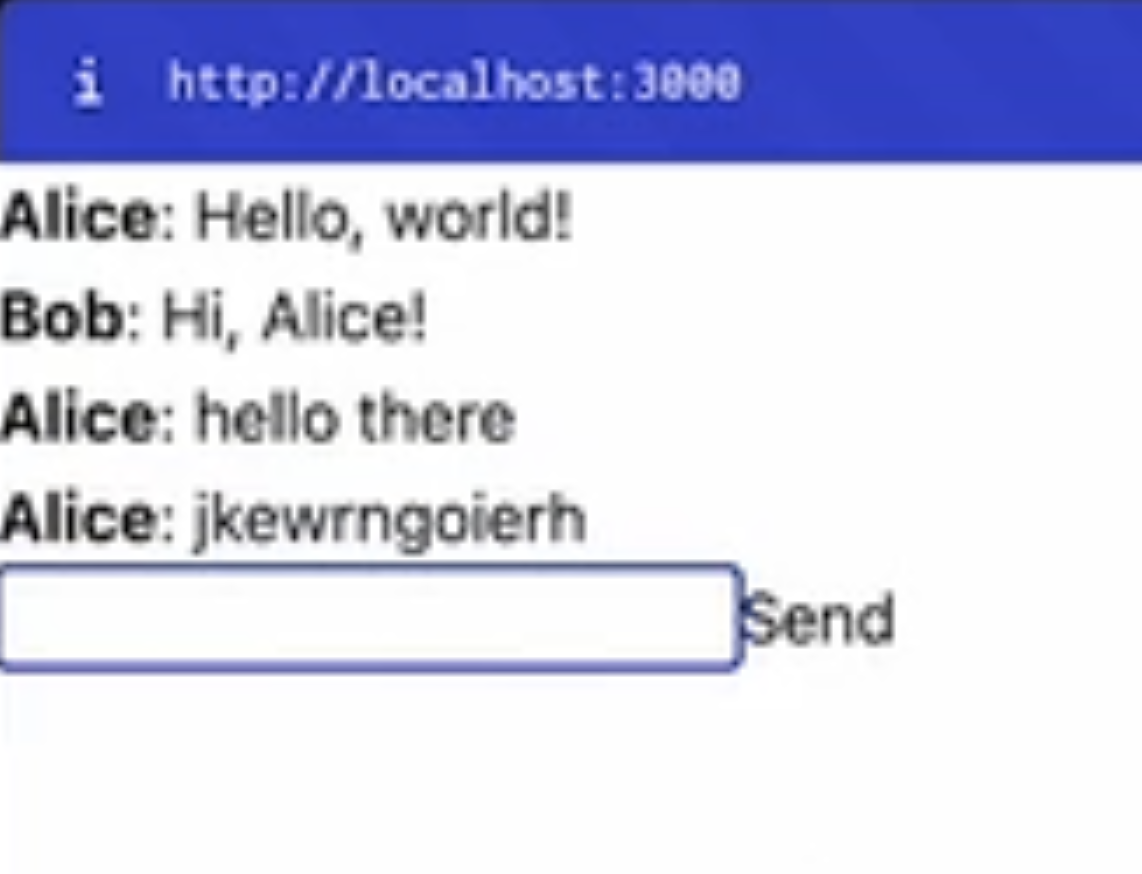

**STEPS**
* Import `useState` from React and define a `Message` interface with `sender` and `content` as string properties.
* Set up messages state using useState, initializing it with sample messages, and create input state as an empty string.
* Create a handleSubmit function to prevent default form behavior, add a new message using the input value, and reset input.
* Render Messages and Input Form:
  * Map over messages to display each message.
  * Add a form with an input field bound to input, an onChange event to update input, and a submit button labeled “Send.”

---
**CODE**: _src/app/page.tsx_

```typescript
import { useState } from "react";

interface Message {
    sender: string;
    content: string;
}

export default function Home() {
  const [messages, setMessages] = useState<Message[]>([
      { sender: 'Alice', content: 'Hello World'},
      { sender: 'Bob', content: "hi, alice!'},
  ]);
  const [input, setInput] = useState("");
    
  const handleSubmit = (event: React.FormEvent<HTMLFormElement>) => {
    event.preventDefault();
    createMessage({ sender: 'Alice', content: input})
    setInput("");
  }
    
  return (
    <>
    <div>
      {messages?.map( (message, index) => (
      <div key={index}>
        <strong>{message.sender}</strong>: {message.content}
      </div>
      ))}
      <form onSubmit={handleSubmit}>
        <input 
          type='text' 
          name='message' 
          id='message' 
          value={input} 
          onChange={e => setInput(e.target.value) }
        />
        <button type='submit'>Send</button>
      </form>

    </div>
    </>
  )
```

# Add Convex to make our static UI connect to a database

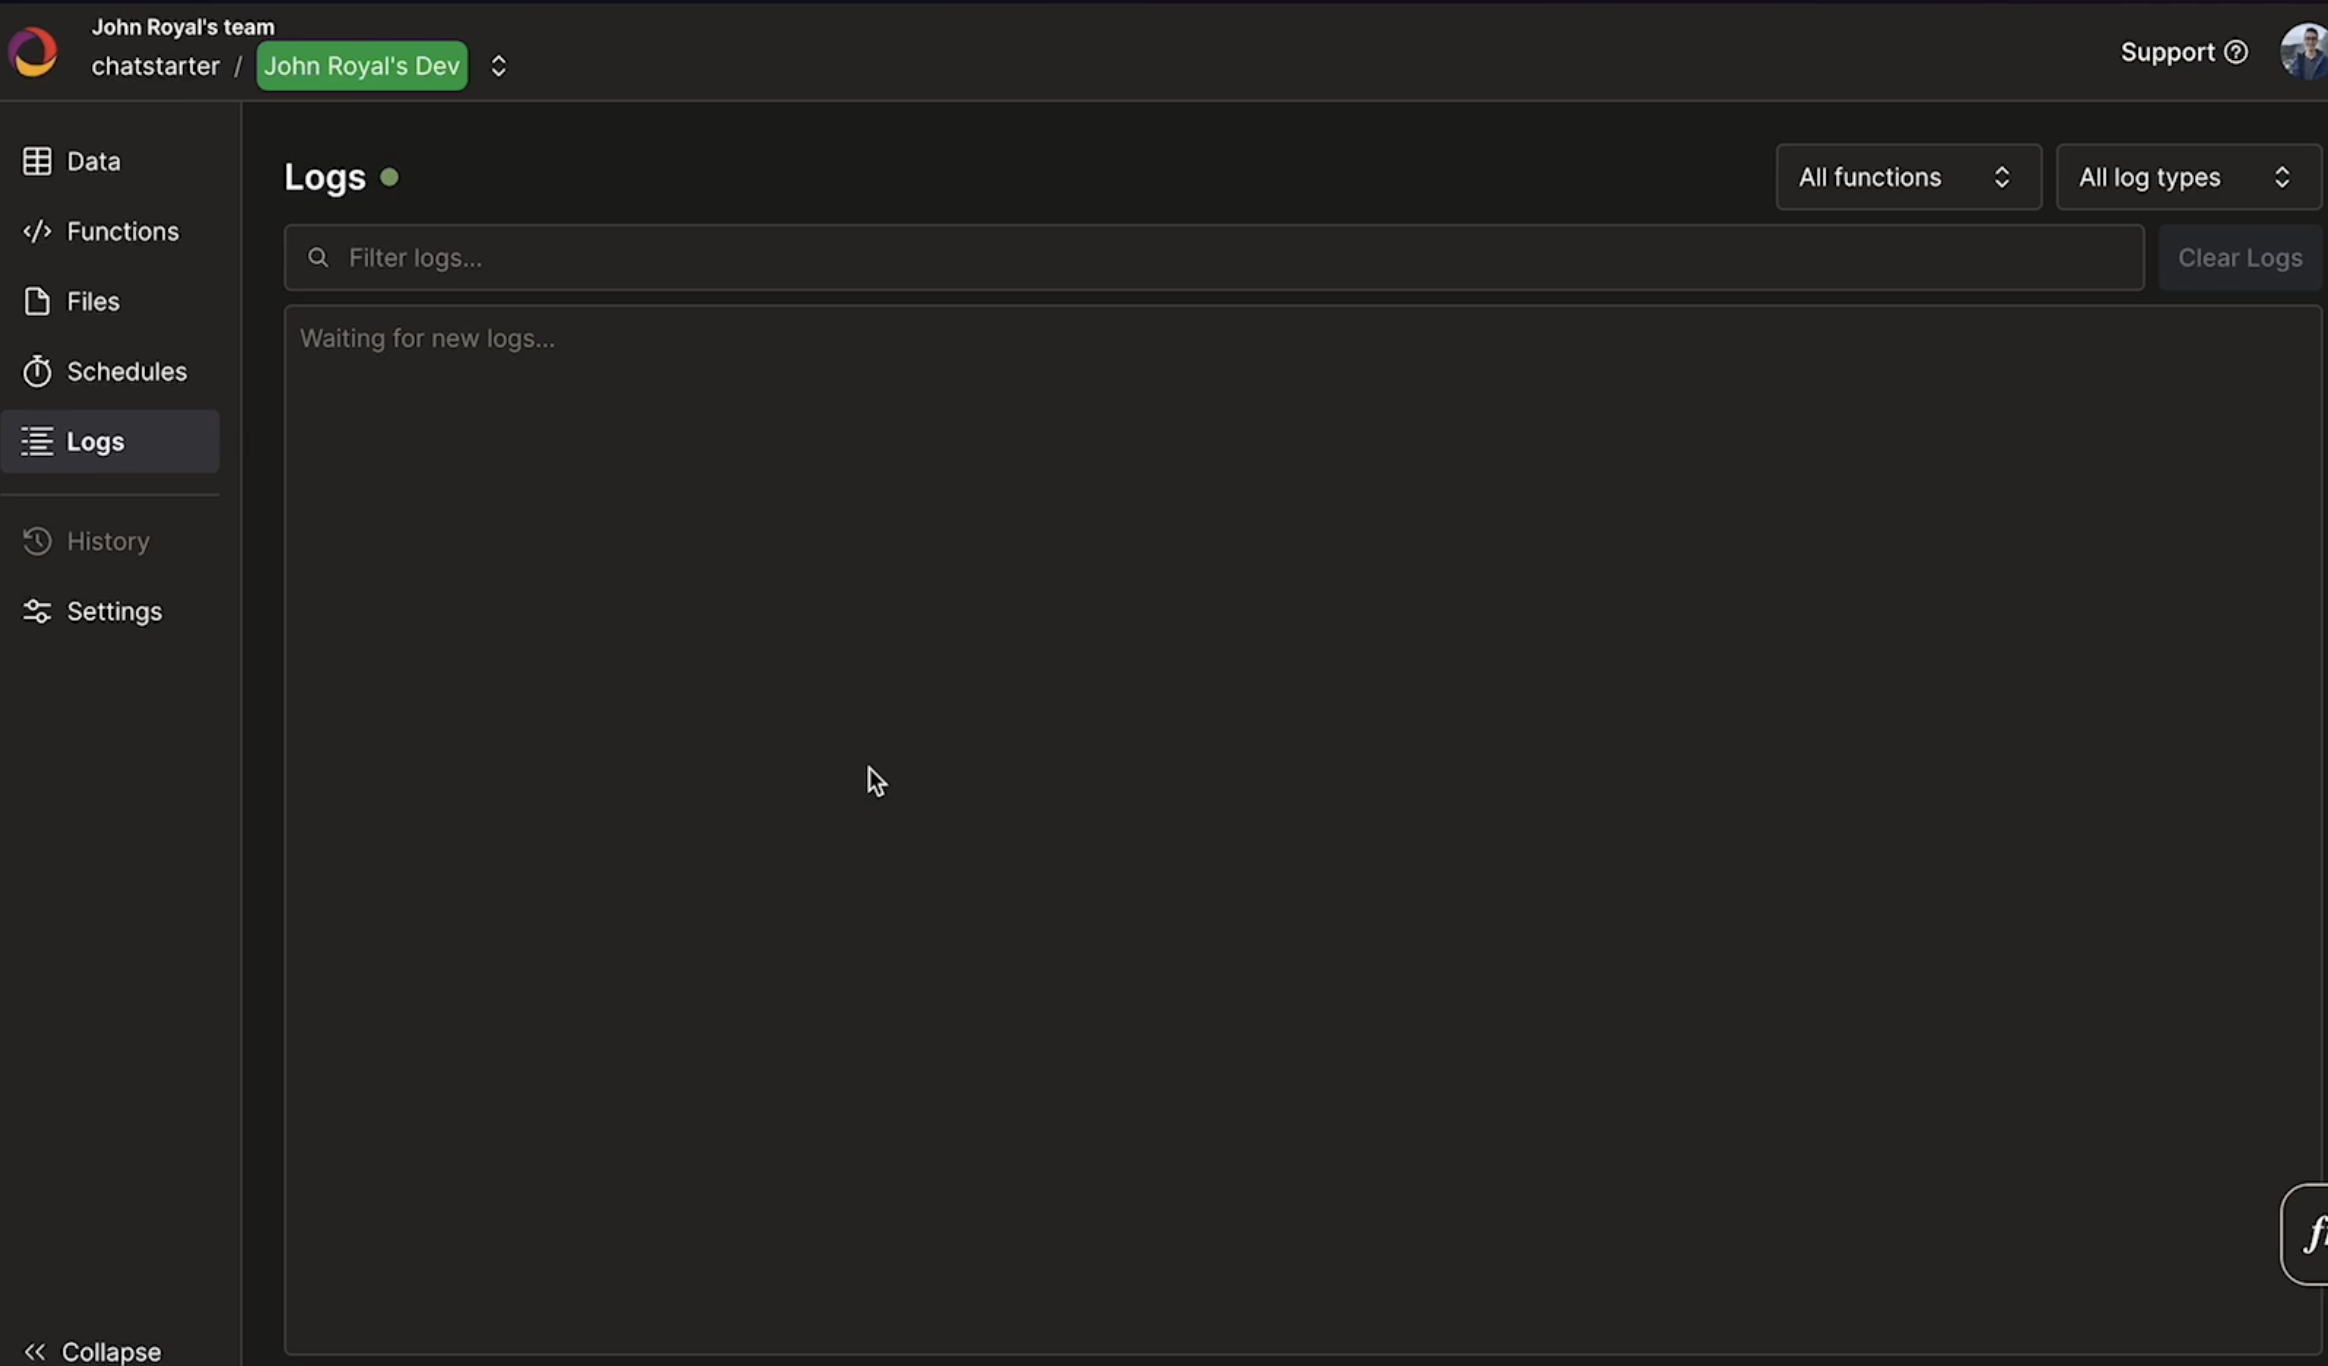

# Create a DB Schema

**STEPS**
* To set up a schema for user and message data, start by importing defineSchema and defineTable from "convex/server", and the v validation utility from "convex/values".
* Use defineSchema to define tables for messages. Define fields sender and content, both also validated as strings. 

---
**CODE**: _convex/schema.ts_

```typescript
import { defineSchema, defineTable } from "convex/server";
import { v } from "convex/values";

export default defineSchema({
    messages: defineTable({
        sender: v.string(),
        content: v.string(),
    })
});
```

# Define functions to interact with messages table through Convex
**SOURCE**: [Convex queries](https://docs.convex.dev/functions/query-functions)  |  [Convex mutation](https://docs.convex.dev/functions/mutation-functions)

**Queries**: fetch data from the database, check authentication or peform other business logic, and return data back to the client application. The same rules apply to mutations and actions, while HTTP actions use a different routing approach.

**Mutations**: Mutations insert, update and remove data from the database, check authentication or perform other business logic, and optionally return a response to the client application.

**Query/Mutations Constructor**: To actually declare a `query` in Convex you use the query constructor function. Pass it an object with a `handler` function, which returns the query result.

**Query/Mutations Arguments**: Queries accept named arguments. The argument values are accessible as fields of the second parameter of the handler function. Arguments and responses are automatically serialized and deserialized, and you can pass and return most value-like JavaScript data to and from your query. To both declare the types of arguments and to validate them, add an args object using v validators.

**Query Context**: The query constructor enables fetching data, and other Convex features by passing a QueryCtx object to the handler function as the first parameter. Which part of the query context is used depends on what your query needs to do:
* Fetch from the database use the `db` field. Note that we make the handler function an `async` function so we can `await` the promise returned by `db.get()`:
* Return URLs to stored files use the storage field.
* Check user authentication use the auth field.



**Mutation Constructor**: To declare a mutation in Convex use the mutation constructor function. Pass it an object with a handler function, which performs the mutation

---
**CODE**: _convex/functions/message.ts_

```typescript
import { mutation, query } from "../_generated/server";
import { v } from 'convex/values';

export const list = query({
    handler: async (ctx) => {
        return await ctx.db.query("messages").collect();
    },
});

export const create = mutation({
    args: {
        sender: v.string(),
        content: v.string(),
    },
    handler: async (ctx, { sender, content}) => {
        await ctx.db.insert('messages', { sender, content });
    },
})
```
---
**CODE**: _convex/functions/user.ts_

```typescript
import { 
    internalMutation, 
    MutationCtx, 
    query, 
    QueryCtx } from '../_generated/server';
import { v } from 'convex/values';

export const get = query({
    handler: async (ctx) => {
        return await getCurrentUser(ctx);
    },
})

export const upsert = internalMutation({
    args: { 
        username: v.string(),
        image: v.string(),
        clerkId: v.string(),
    },
    handler: async (ctx, args) => {
        const user = await getUserByClerkid(ctx, args.clerkId)

        // If user is found, update. Otherwise, create new user
        if (user) {
            await ctx.db.patch(user._id, {
                username: args.username,
                image: args.image,
            })
        } else {
            await ctx.db.insert('users', {
                username: args.username,
                image: args.image,
                clerkId: args.clerkId,
            });
        }
    },
});

export const remove = internalMutation({
    args: { clerkId: v.string() },
    handler: async (ctx, args) => {
        const user = await getUserByClerkid(ctx, args.clerkId)

        // If user is found, delete.
        if (user) {
            await ctx.db.delete(user._id);
        }
    },
})

const getCurrentUser = async (ctx: QueryCtx | MutationCtx) => {
    const identity = await ctx.auth.getUserIdentity();
    if (!identity) {
        return null;
    }
    return await getUserByClerkid(ctx, identity.subject)
}

const getUserByClerkid = async (
    ctx: QueryCtx | MutationCtx, 
    clerkId: string
) => {
    return await ctx.db
        .query('users')
        .withIndex('by_clerk_id', (q) => q.eq('clerkId', clerkId))
        .unique();
}
```
---

This code should run both next and convex

**CODE**: package.json
```json
{
    ...
    "scripts": {
        "dev" : "run-p dev:*",
        "dev:convex" : "convex dev",
        "dev:next" : "next dev --turbopack",
    }
    ...
}
```

# Create a client component for the Convex provider
[Convex Quickstart](https://docs.convex.dev/quickstart/nextjs)
Add a new file `ConvexClientProvider.tsx` in the `app/` folder. Include the `"use client";` directive, create a `ConvexReactClient` and a component that wraps its children in a `ConvexProvider`. The `NEXT_PUBLIC_CONVEX_URL` should already added in `.env.local` when we signed up with Convex.

---
**CODE**: _src/app/ConvexClientProvider.tsx_
```typescript
"use client";

import { ConvexReactClient } from "convex/react";
import { ConvexProviderWithClerk } from 'convex/react-clerk' 
import { ReactNode } from "react";
import { useAuth } from '@clerk/nextjs';

const convex = new ConvexReactClient(process.env.NEXT_PUBLIC_CONVEX_URL!);

export function ConvexClientProvider({ 
    children, 
}: { 
    children: ReactNode 
}) {
  return (
    <ConvexProviderWithClerk client={convex} useAuth={useAuth}>
        {children}
    </ConvexProviderWithClerk>
  )
}
```

# Wire up the ConvexClientProvider
In `app/layout.tsx`, wrap the children of the body element with the `ConvexClientProvider`.

---
**CODE**: _src/app/layout/tsx_
```typescript

import type { Metadata } from "next";
import "./globals.css";
import { ConvexClientProvider } from "./ConvexClientProvider";
import {
  ClerkProvider,
} from '@clerk/nextjs'



export const metadata: Metadata = {
  title: "Create Next App",
  description: "Generated by create next app",
};

export default function RootLayout({
  children,
}: Readonly<{
  children: React.ReactNode;
}>) {
  return (
    <ClerkProvider dynamic>
    <html lang="en">
      <body>
        <ConvexClientProvider>{children}</ConvexClientProvider>
      </body>
    </html>
    </ClerkProvider>
  );
}

```

# Display the data in your app
In `app/page.tsx`, use the `useQuery` hook to fetch from your `api.functions.message` API function.

---
**CODE**: _src/app/page.tsx_
```typescript
'use client'

import { useMutation, useQuery } from 'convex/react'; 
import { useState } from "react";
import { api } from "../../convex/_generated/api";

export default function Home() {
  const messages = useQuery(api.functions.message.list)
  const createMessage = useMutation(api.functions.message.create)
  const [input, setInput] = useState("");

  const handleSubmit = (event: React.FormEvent<HTMLFormElement>) => {
    event.preventDefault();
    createMessage({ sender: 'Alice', content: input})
    setInput("");
  }

  return (
    <>
    <div>
      {messages?.map( (message, index) => (
      <div key={index}>
        <strong>{message.sender}</strong>: {message.content}
      </div>
      ))}
      <form onSubmit={handleSubmit}>
        <input 
          type='text' 
          name='message' 
          id='message' 
          value={input} 
          onChange={e => setInput(e.target.value) }
        />
        <button type='submit'>Send</button>
      </form>

    </div>
    </>
  )
}
```

When you execute a mutation, all the queries will update automatically across clients because they are all connected to the convex realtime API.

# Setting up Clerk and Convex
**SOURCE**: 
* [Clerk Quickstart](https://clerk.com/docs/quickstarts/nextjs)
* [Convex Clerk Auth](https://docs.convex.dev/auth/clerk)

**STEPS**
* Go to [Clerk dashboard](https://dashboard.clerk.com/apps/app_2oGaC1K1kHQ72iyoOJ3IRSW8bbY/instances/ins_2oGaC6oUHHOguvE9r3DztKHYCnG/user-authentication/email-phone-username).
* Create the application.
* Install `pnpm add @clerk/nextjs`
* Set your environment variables to your `.env.local`. Retrieve the key from the `Dashboard/configure/API` keys page

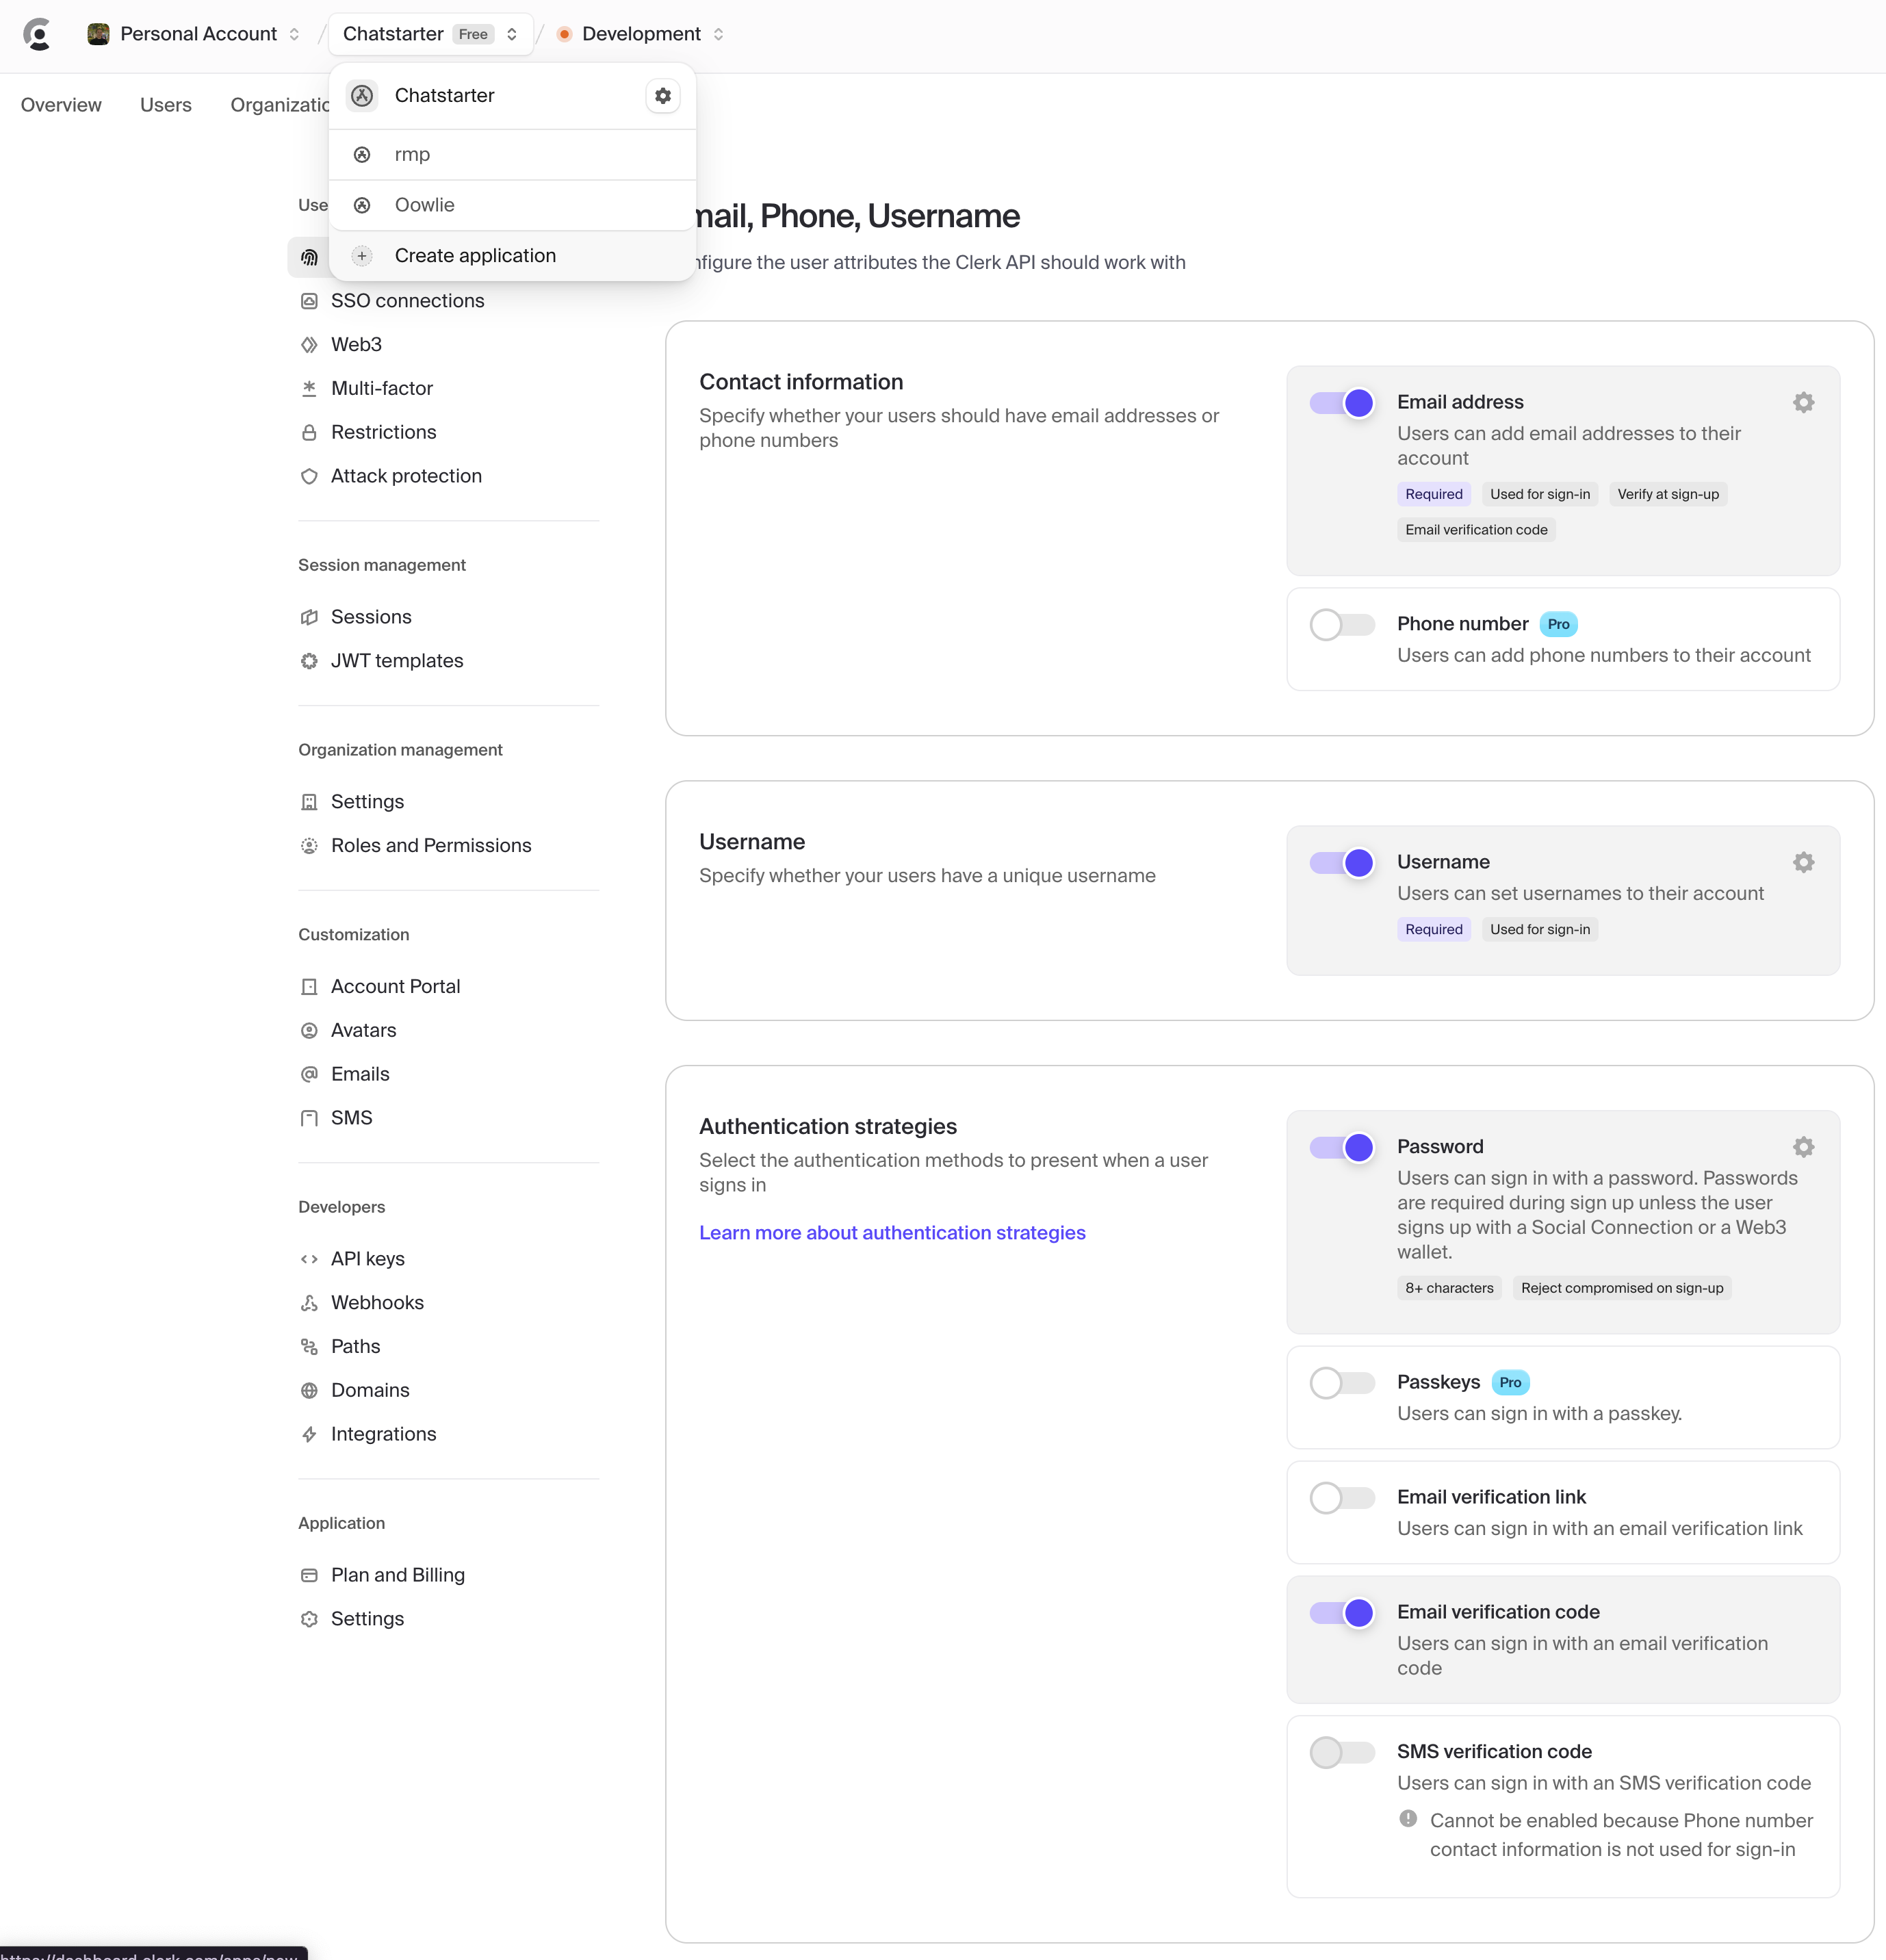

# Add clerkMiddleware() to your app
`clerkMiddleware()` grants you access to user authentication state throughout your app, on any route or page. It also allows you to protect specific routes from unauthenticated users. To add `clerkMiddleware()` to your app, follow these steps:

* Create a `middleware.ts` file.
    * If you're using the /src directory, create middleware.ts in the /src directory.
    * If you're not using the /src directory, create middleware.ts in the root directory alongside .env.local.
* In your middleware.ts file, export Clerk's clerkMiddleware() helper:
---
**CODE**: _src/middleware.ts_
```typescript
import { clerkMiddleware } from '@clerk/nextjs/server'

export default clerkMiddleware()

export const config = {
  matcher: [
    // Skip Next.js internals and all static files, unless found in search params
    '/((?!_next|[^?]*\\.(?:html?|css|js(?!on)|jpe?g|webp|png|gif|svg|ttf|woff2?|ico|csv|docx?|xlsx?|zip|webmanifest)).*)',
    // Always run for API routes
    '/(api|trpc)(.*)',
  ],
}
```

# Create a JWT Template
This is how we are going to Convex what the user from Clerk is and for them to be able to connect with each other. In the clerk dashboard, go to configure and scroll down to to Jason Web token template.

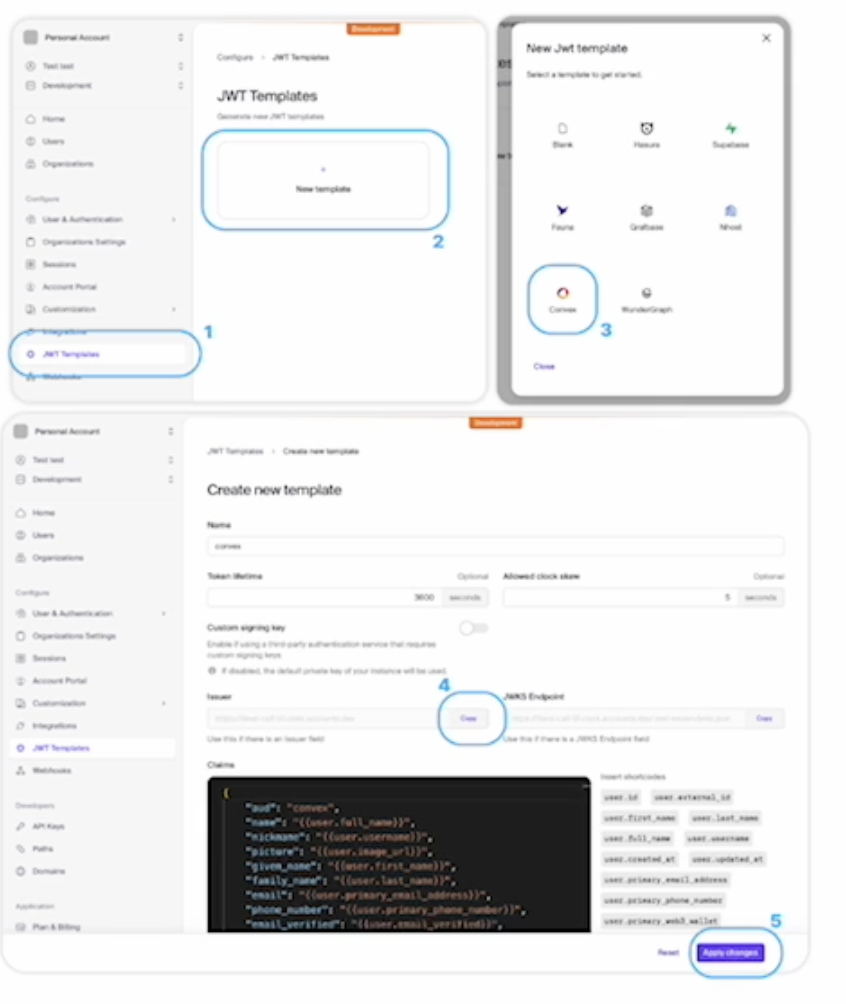

* In the JWT Templates section of the Clerk dashboard tap on + New template and choose Convex
* Copy the Issuer URL from the Issuer input field.
* Hit Apply Changes.

Note: Do NOT rename the JWT token, it must be called convex.

# Create the auth config
In the convex folder create a new file auth.config.ts with the server-side configuration for validating access tokens.

Paste in the Issuer URL from the JWT template and set applicationID to "convex" (the value of the "aud" Claims field).

---
**CODE**: _convex/auth_config.ts_
```typescript
const clerkConfig = {
  providers: [
    {
      domain: "https://tops-worm-73.clerk.accounts.dev",
      applicationID: "convex",
    },
  ],
};

export default clerkConfig;
```

# Add `<ClerkProvider>` and Clerk components to your app

The `<ClerkProvider>` component wraps your app to provide active session and user context to Clerk's hooks and other components.

---
**CODE**: _src/app/layout.tsx_

```typescript
import type { Metadata } from "next";
import "./globals.css";
import { ConvexClientProvider } from "./ConvexClientProvider";
import {
  ClerkProvider,
} from '@clerk/nextjs'

export const metadata: Metadata = {
  title: "Create Next App",
  description: "Generated by create next app",
};

export default function RootLayout({
  children,
}: Readonly<{
  children: React.ReactNode;
}>) {
  return (
    <ClerkProvider dynamic>
    <html lang="en">
      <body>
        <ConvexClientProvider>{children}</ConvexClientProvider>
      </body>
    </html>
    </ClerkProvider>
  );
}

```

---
**CODE**: _src/app/ConvexClientProvider.tsx_
```typescript
"use client";

import { ConvexReactClient } from "convex/react";
import { ConvexProviderWithClerk } from 'convex/react-clerk' 
import { ReactNode } from "react";
import { useAuth } from '@clerk/nextjs';

// Define Convex client
const convex = new ConvexReactClient(process.env.NEXT_PUBLIC_CONVEX_URL!);

export function ConvexClientProvider({ 
    children, 
}: { 
    children: ReactNode 
}) {
  return (
    <ConvexProviderWithClerk client={convex} useAuth={useAuth}>
        {children}
    </ConvexProviderWithClerk>
  )
}
```